In [29]:
import importlib

import pandas as pd
import numpy as np
np.random.seed(0)

from sklearn.preprocessing import minmax_scale

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb

from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('../input/allstate.train.csv')

In [3]:
train.info()
#train.info(max_cols=140)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [4]:
train.columns.values

array(['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7',
       'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14',
       'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21',
       'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28',
       'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35',
       'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42',
       'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49',
       'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56',
       'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63',
       'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70',
       'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77',
       'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84',
       'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91',
       'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98',
       'cat99', 'cat100

In [5]:
train.sample(10)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
74790,233824,A,A,A,A,A,B,A,A,A,...,0.438917,0.447174,0.60087,0.35127,0.43919,0.374064,0.366307,0.611431,0.254988,1128.97
22054,69520,A,B,A,A,B,A,A,A,B,...,0.596448,0.474881,0.68308,0.79047,0.60932,0.625936,0.612906,0.723122,0.765010,1791.28
25894,81359,A,A,A,B,A,B,A,A,A,...,0.666096,0.590329,0.49462,0.45391,0.56627,0.625936,0.612906,0.689974,0.289668,1692.98
3604,11498,B,A,A,A,A,B,A,A,A,...,0.430536,0.664223,0.26847,0.41471,0.47779,0.711942,0.698722,0.304350,0.347694,698.35
178001,555461,A,B,A,A,A,A,A,A,B,...,0.623302,0.574825,0.54829,0.38249,0.45017,0.607500,0.630853,0.666708,0.242690,818.20
6607,21012,A,B,A,B,A,A,A,A,B,...,0.272540,0.295775,0.50060,0.33611,0.31480,0.257148,0.264760,0.339244,0.731836,820.29
174126,543488,A,B,A,A,B,A,A,A,B,...,0.516518,0.538449,0.88205,0.32311,0.36458,0.291268,0.286079,0.717751,0.290422,1371.66
3418,10892,A,A,A,A,B,A,A,A,A,...,0.240069,0.283691,0.24564,0.30859,0.32446,0.223038,0.220003,0.333292,0.304517,1557.90
68035,212816,A,B,A,A,A,A,A,A,B,...,0.279355,0.350625,0.58934,0.23569,0.27777,0.307628,0.305148,0.592264,0.470705,2744.22
60637,189942,A,B,A,A,A,A,A,A,B,...,0.419042,0.394542,0.41762,0.34365,0.29595,0.307628,0.318249,0.391741,0.210185,869.67


In [6]:
if 'id' in train: del train['id']

### Target variable - `loss`

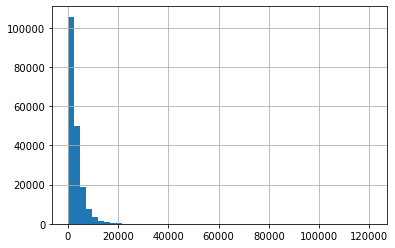

In [7]:
train['loss'].hist(bins=50);

In [8]:
train['loss'].describe()

count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64

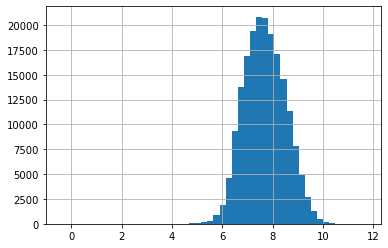

In [9]:
train['log_loss'] = np.log( train['loss'] )
train['log_loss'].hist(bins=50);

In [10]:
train.select_dtypes(include=[np.number]).columns.values

array(['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14',
       'loss', 'log_loss'], dtype=object)

In [11]:
def get_feats(df):
    black_list = ['loss', 'log_loss']
    feats = df.select_dtypes(include=[np.number]).columns.values
    
    feats = [feat for feat in feats if feat not in black_list]
    return feats
    
def get_X_y(df, target='loss', verbose=False):
    feats = get_feats(df)
    if verbose: print(feats)
        
    X = df[ feats ].values
    y = df[ target ].values
    
    return X, y

X, y = get_X_y(train)

In [12]:
def run_cv(X, y, model, folds=3):
    cv = KFold(n_splits=folds, shuffle=True, random_state=0)

    scores = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])

        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)


def run_log_cv(X, y, model, folds=3, shift = 1):
    y_log = np.log(y + shift)
    
    cv = KFold(n_splits=folds, shuffle=True, random_state=0)

    scores = []
    for train_idx, test_idx in cv.split(X):
        model.fit(X[train_idx], y_log[train_idx])
        y_log_pred = model.predict(X[test_idx])
        y_log_pred[ y_log_pred < 0 ] = 1e-6
        
        y_pred = np.exp( y_log_pred ) - shift

        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)

In [13]:
run_cv(X, y, LinearRegression())

(1950.6093145182822, 5.26358554128088)

## Decision Tree & Random Forest & Extra Trees


In [14]:
run_cv(X, y, DecisionTreeRegressor(max_depth=5, random_state=0))

(1937.9800852451642, 7.781449866906199)

In [15]:
run_cv(X, y, RandomForestRegressor(max_depth=5, n_estimators=20, random_state=0))

(1931.6678898211746, 4.796889604811079)

In [16]:
run_cv(X, y, ExtraTreesRegressor(max_depth=5, n_estimators=20, random_state=0))

(1936.8998805112758, 4.917912831742669)

In [17]:
num_feats = [feat for feat in train.columns if 'cont' in feat]
cat_feats = [feat for feat in train.columns if 'cat' in feat]

cat_id_feats = []
for feat in tqdm(cat_feats):
    feat_id = feat + '_id'
    train[feat_id] = train[feat].factorize()[0]
    cat_id_feats.append(feat_id)

100%|██████████| 116/116 [00:01<00:00, 67.08it/s]


In [18]:
X, y = get_X_y(train)

In [19]:
run_cv(X, y, DecisionTreeRegressor(max_depth=5))

(1455.7936294815872, 1.5821340165406927)

## num_feats



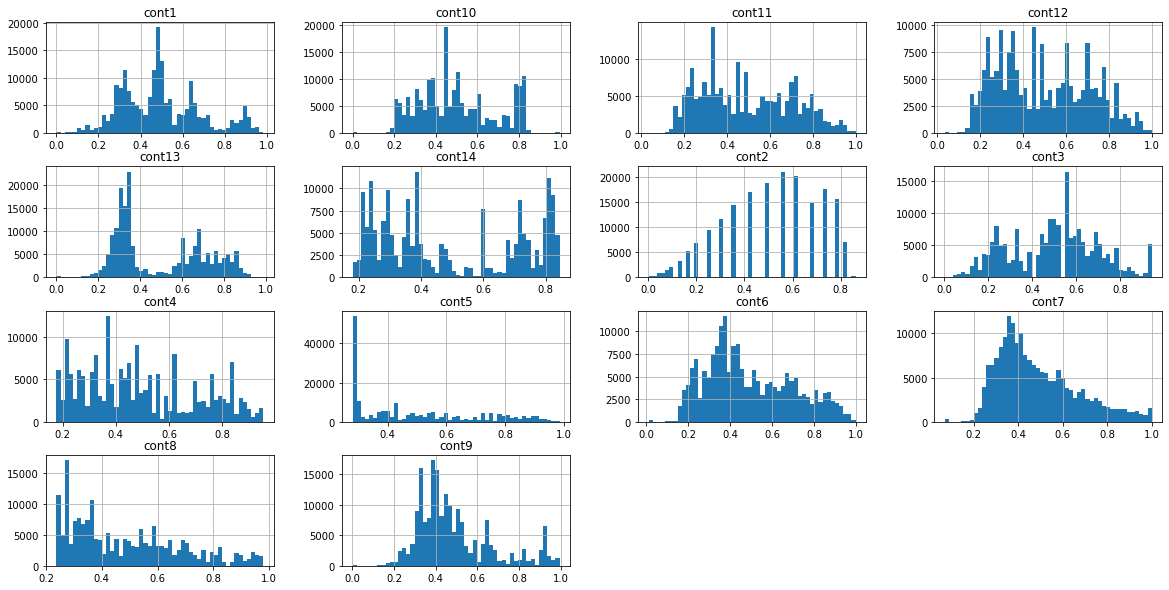

In [20]:
train[ num_feats ].hist(figsize=(20, 10), bins=50);

### Добавление
Начнем со сложения выбранных пар.

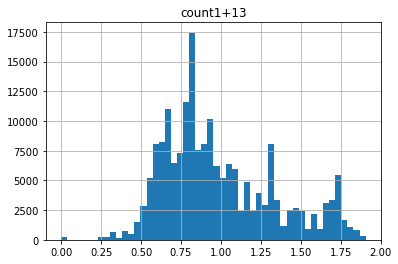

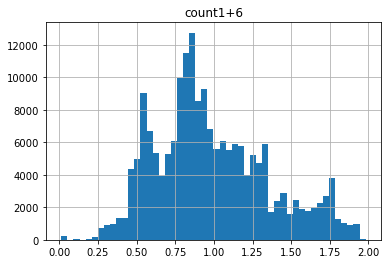

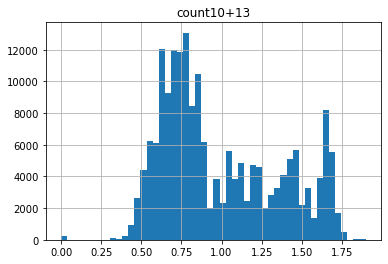

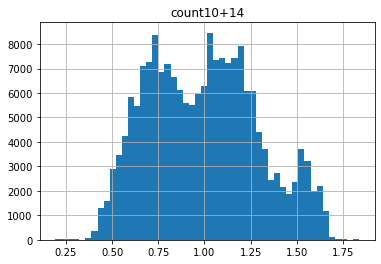

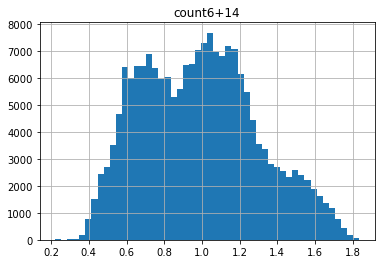

In [21]:
sum_pairs = [
    (1, 13),
    (1, 6),
    (10, 13),
    (10, 14),
    (6, 14),
]
sum_feats = []

for left, right in sum_pairs:
    output_idx = 'count{0}+{1}'.format(left, right)
    train[output_idx] = train['cont{0}'.format(left)] + train['cont{0}'.format(right)]
    sum_feats.append(output_idx)
    
    train[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

### Вычитание
Попробуем также вычесть одно из другого.

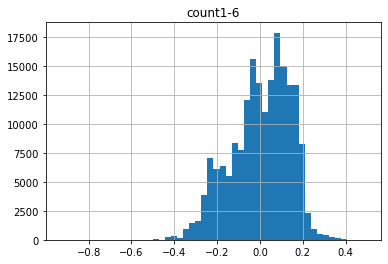

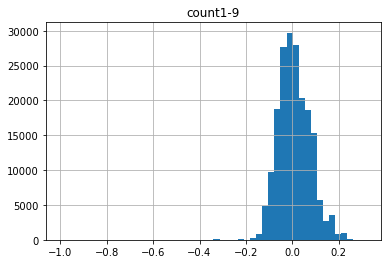

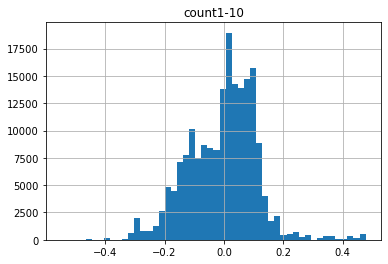

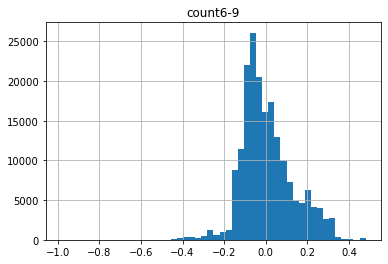

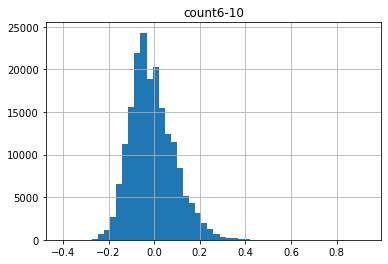

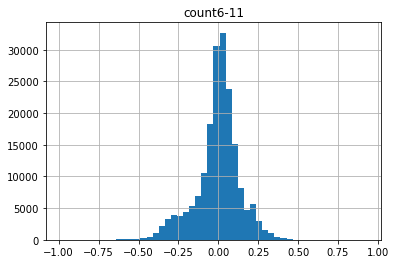

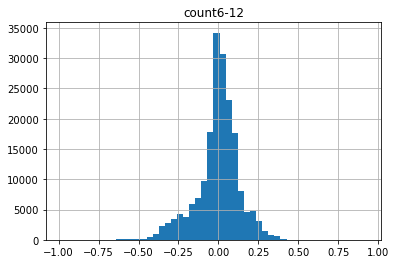

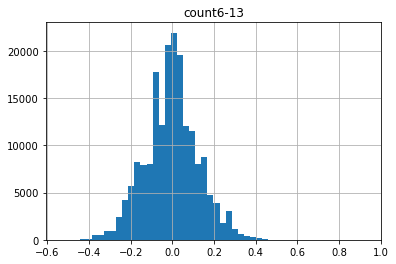

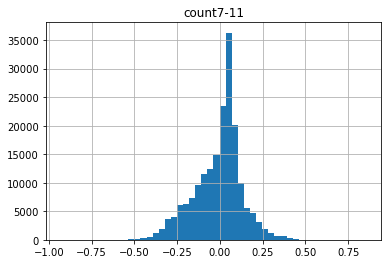

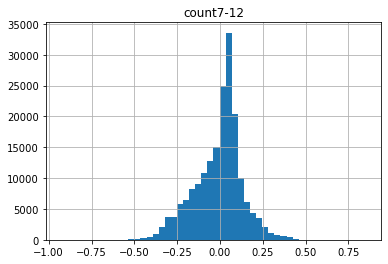

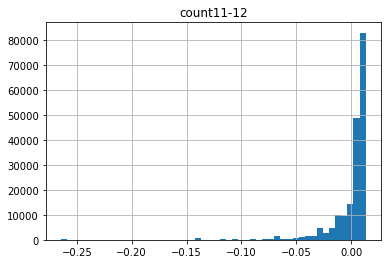

In [26]:
minus_pairs = [
    (1, 6),
    (1, 9),
    (1, 10),
    (6, 9),
    (6, 10),
    (6, 11),
    (6, 12),
    (6, 13),
    (7, 11),
    (7, 12),
    (11, 12)
]

minus_feats = []
for left, right in minus_pairs:
    output_idx = 'count{0}-{1}'.format(left, right)
    train[output_idx] = train['cont{0}'.format(left)] - train['cont{0}'.format(right)]
    minus_feats.append(output_idx)
    
    train[output_idx].hist(bins=50);
    plt.title(output_idx)
    plt.show()

## Оценка важности признаков

In [27]:
def plot_feature_importances(model, feats, limit = 20):
    importances = model.feature_importances_

    indices = np.argsort(importances)[::-1][:limit]

    plt.figure(figsize=(20, 8))
    plt.title("Feature importances")
    plt.bar(range(limit), importances[indices])
    plt.xticks(range(limit), [feats[i] for i in indices], rotation='vertical')
    plt.show()

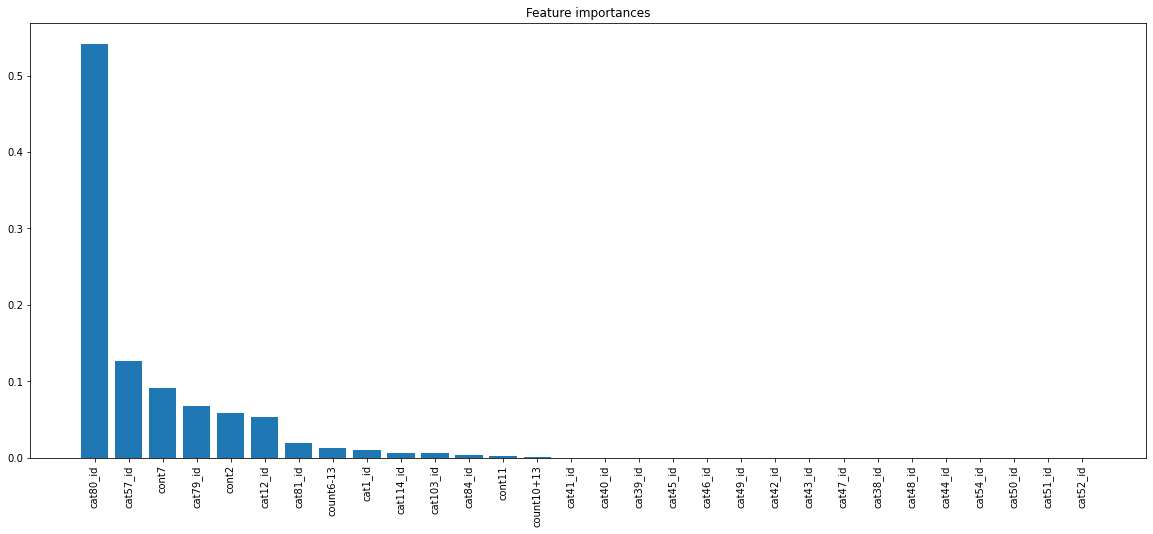

In [30]:
feats = cat_id_feats + num_feats + sum_feats + minus_feats
X = train[feats].values

model = DecisionTreeRegressor(max_depth=5)
model.fit(X, y)

plot_feature_importances(model, feats, limit=30)

## RandomForest
Давай также проверим важность признаков в случае случайных лесов:

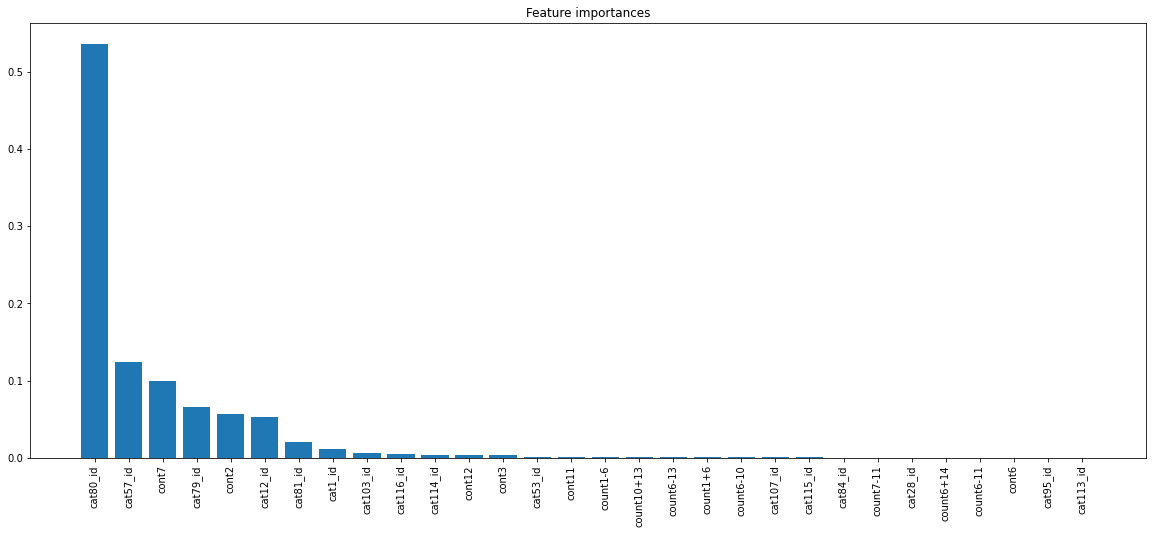

In [31]:
feats = cat_id_feats + num_feats + sum_feats + minus_feats
X = train[feats].values

model = RandomForestRegressor(max_depth=5, n_estimators=20, random_state=0)
model.fit(X, y)

plot_feature_importances(model, feats, limit=30)

В обоих случаях **cat80** идет первым. Можно увидеть, что вновь созданные признаки (сложение или вычитание) также появились среди 30 признаков с наивысшей важностью (например, **count10+13**).

Теперь давай проверим графики для некоторых категориальных переменных (`cat80`,` cat57` и `cat79`) и то, как они влияют на` loss`. `loss` искажен, поэтому будем сравнивать с `log_loss`.

In [32]:
def plot_cat_var_and_loss(cat_id):
    print( train[cat_id].value_counts() )
    print( train[cat_id].value_counts(normalize=True) )

    train[cat_id].hist()
    plt.show()

    print("Loss")
    plt.figure(figsize=(20, 8))
    for i in range(4):
        plt.subplot(221 + i)
        plt.boxplot( train[ train[cat_id] == i ]['loss'] )
        plt.title(cat_id + ' == {0}'.format(i))

    plt.show();

    print("Log Loss")
    plt.figure(figsize=(20, 8))
    for i in range(4):
        plt.subplot(221 + i)
        plt.boxplot( train[ train[cat_id] == i ]['log_loss'] )
        plt.title(cat_id + ' == {0}'.format(i))
        plt.ylim(0, 12)

    plt.show();

## Cat80

0    137505
1     46538
3      3492
2       783
Name: cat80_id, dtype: int64
0    0.730174
1    0.247125
3    0.018543
2    0.004158
Name: cat80_id, dtype: float64


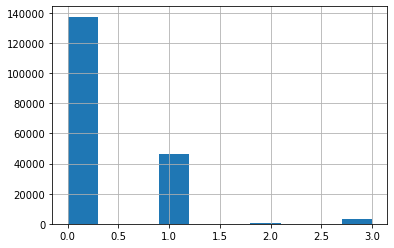

Loss


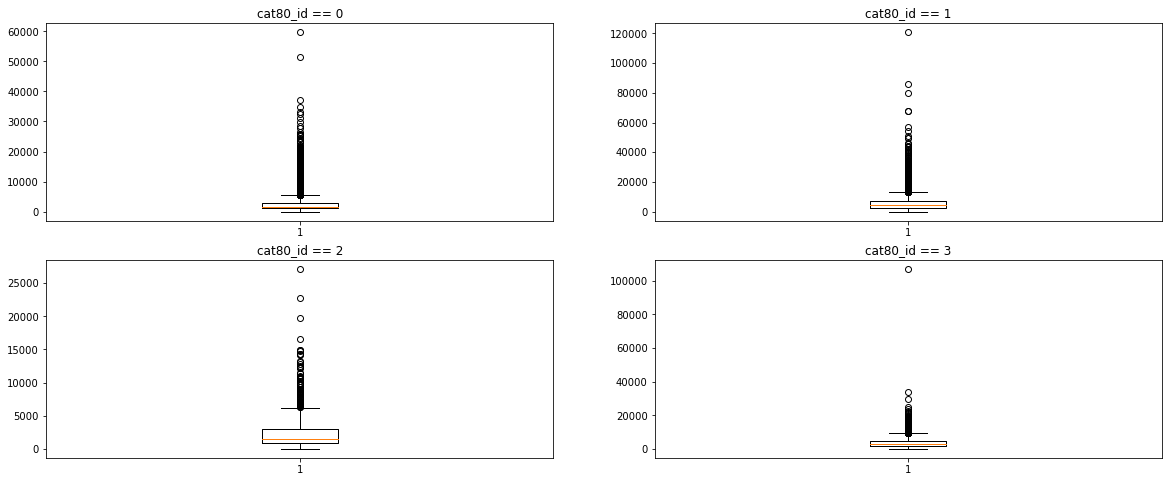

Log Loss


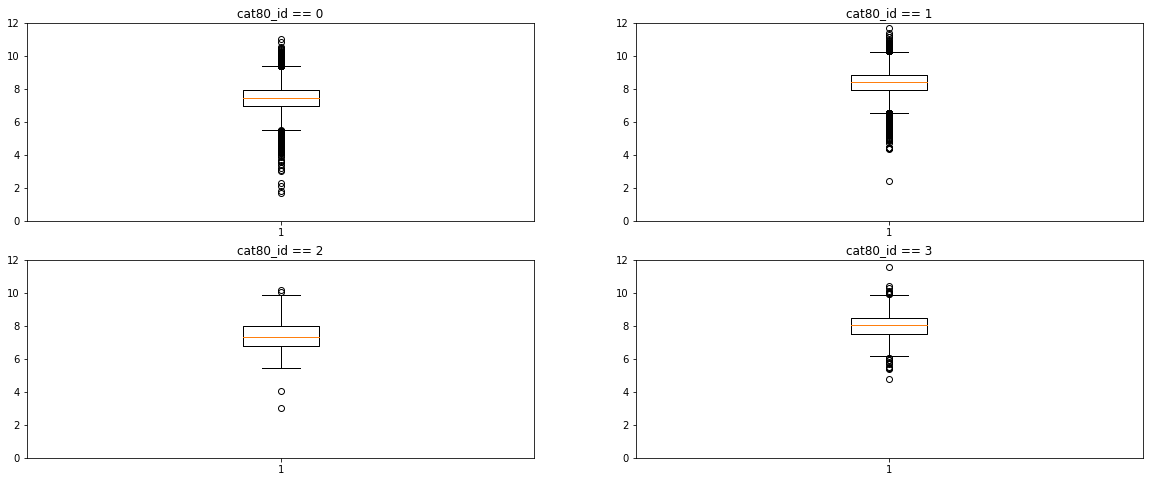

In [33]:
plot_cat_var_and_loss('cat80_id')

## Cat 57

0    185296
1      3022
Name: cat57_id, dtype: int64
0    0.983953
1    0.016047
Name: cat57_id, dtype: float64


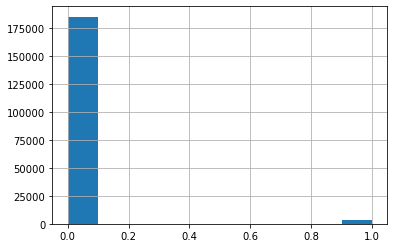

Loss


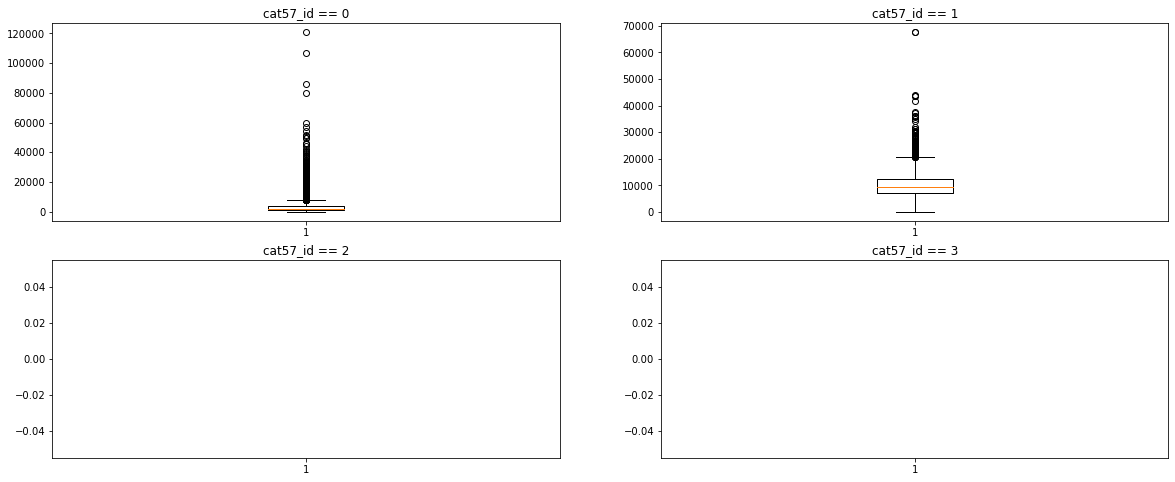

Log Loss


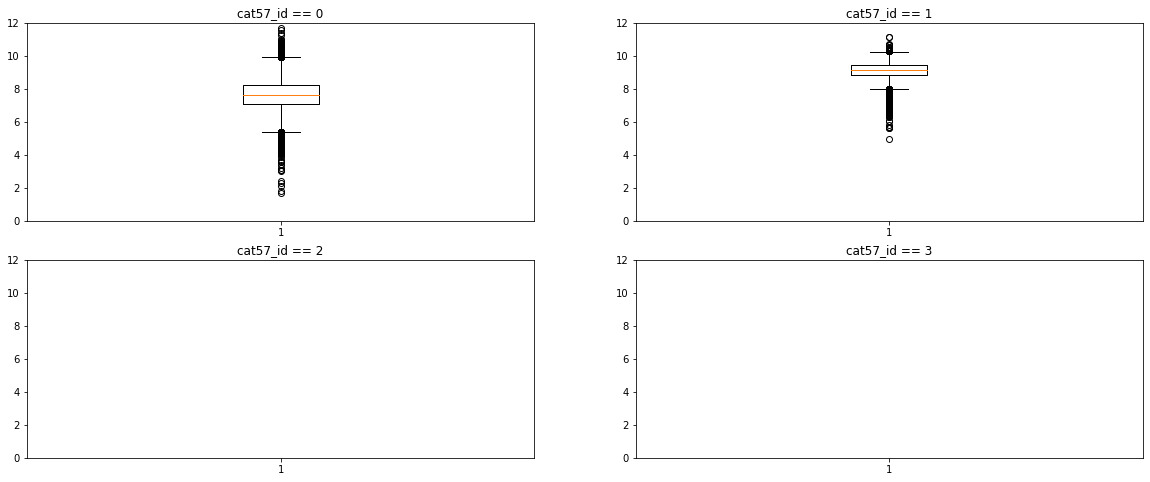

In [34]:
plot_cat_var_and_loss('cat57_id')

0    152929
1     26657
2      7064
3      1668
Name: cat79_id, dtype: int64
0    0.812079
1    0.141553
2    0.037511
3    0.008857
Name: cat79_id, dtype: float64


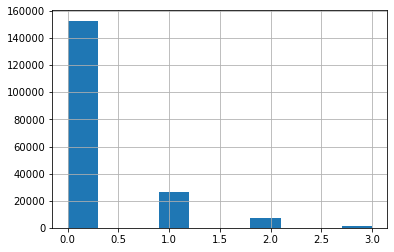

Loss


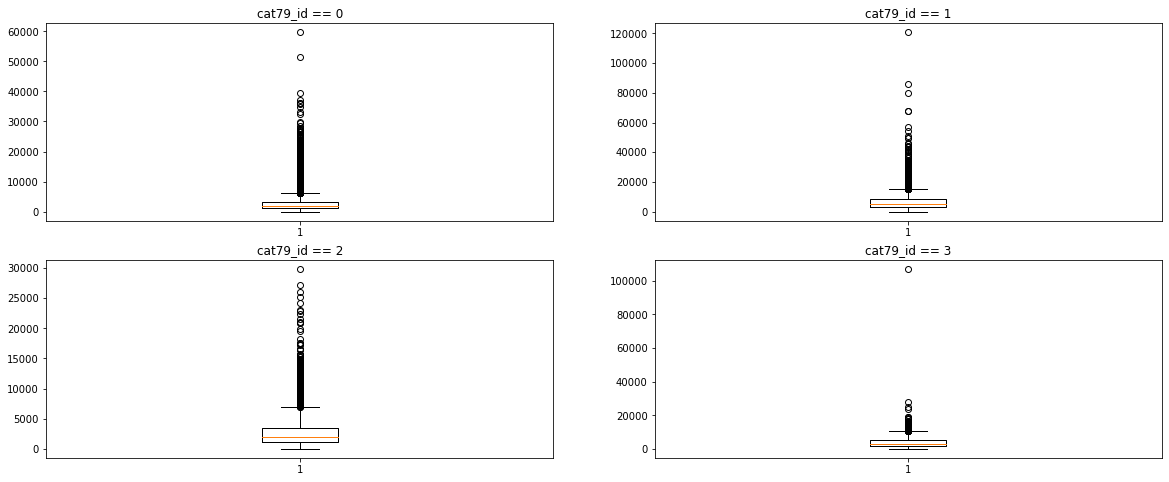

Log Loss


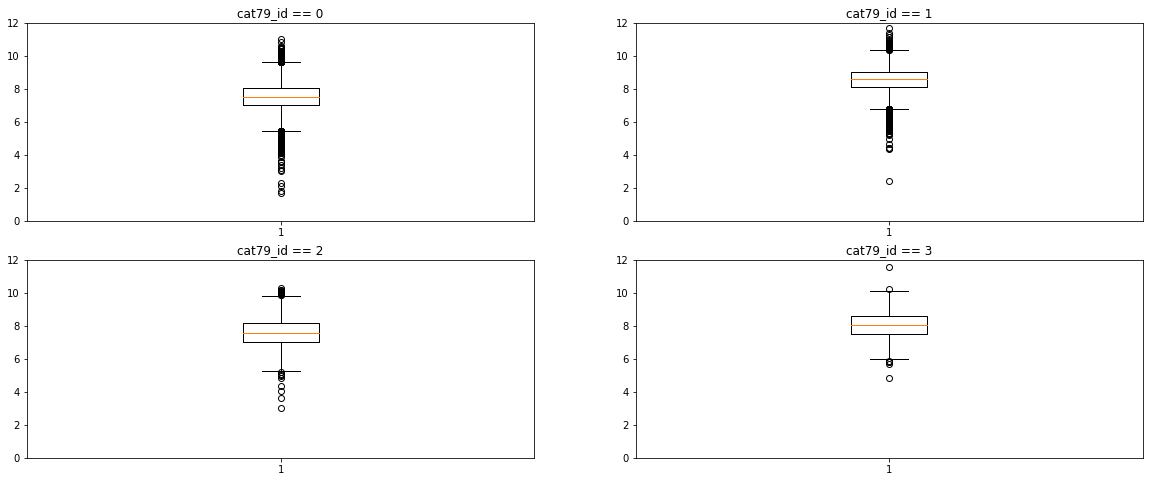

In [35]:
plot_cat_var_and_loss('cat79_id')

Можно увидеть, что когда мы используем исходную величину (**loss**), тогда появляется много выбросов, но после логарифмического преобразования это становится более разумным. Поэтому мы начнем применять `log(loss)`.

## Log loss

Теперь мы построим модель на основе `log(loss)`. Давай также рассмотрим смещение `log (loss + shift)`, выбрав другой параметр `shift`.

## Log loss

Теперь мы построим модель на основе `log(loss)`. Давай также рассмотрим сдвиг `log (loss + shift)`, выбрав другой параметр `shift`.

In [36]:
X = train[ cat_id_feats + num_feats + sum_feats + minus_feats  ].values

run_log_cv(X, y, DecisionTreeRegressor(max_depth=5))

(1390.2324895797137, 11.928682612041111)

Есть улучшение: ~**1391** vs ~**1455**. Хорошо, продолжим применять `log(loss)`.

## XGBoost

Теперь перейдем к к максимальным оборотам и воспользуемся для этого `xgboost`. Проведем серию экспериментов, чтобы увидеть, как меняется качество в зависимости от набора признаков.

In [37]:
X = train[ cat_id_feats + num_feats + sum_feats + minus_feats  ].values
run_cv(X, y, xgb.XGBRegressor(objective='reg:squarederror'))

(1209.2480124921601, 3.5324401564140837)

**XGBoost** с самого начала показал хорошие результаты: ~**1209** vs ~**1387**.


## Advanced XGBoost
Для начала определим несколько функций, чтобы не повторяться.

In [38]:
shift = 1
def eval_mae(y_pred_log, dtrain):
    y      = np.exp(dtrain.get_label()) - shift
    y_pred = np.exp(y_pred_log) - shift
    
    return 'mae', mean_absolute_error(y,y_pred)

In [39]:
def plot_xgb_learning_curve(train_evals, test_evals):
    mean_train_evals = np.mean(train_evals, axis=0)
    std_train_evals = np.std(train_evals, axis=0)

    mean_test_evals = np.mean(test_evals, axis=0)
    std_test_evals = np.std(test_evals, axis=0)

    plt.figure(figsize=(15, 5))

    plt.fill_between(range(len(mean_train_evals)), mean_train_evals - std_train_evals*3,
                     mean_train_evals + std_train_evals*3, alpha=0.1,
                     color="r")

    plt.fill_between(range(len(mean_test_evals)), mean_test_evals - std_test_evals*3,
                     mean_test_evals + std_test_evals*3, alpha=0.1,
                     color="g")


    plt.plot(mean_train_evals, label='train', c='r')
    plt.plot(mean_test_evals, label='test', c='g')
    plt.legend(loc='best')
    plt.title("Learning curve")
    plt.xlabel("# iterations")
    plt.ylabel("mae")
    plt.show()
    
    
def cv_xgb(df, feats, xgb_params, shift=1, folds=3, verbose=False, early_stopping_rounds=5, plot_lc=True, return_model=False):
    X = df[ feats ].values
    y = df['loss'].values
    y_log = np.log( y + shift )
    
    cv = KFold(n_splits=3, shuffle=True, random_state=2019)

    scores = []
    train_evals, test_evals = [], []
    for train_idx, test_idx in tqdm( cv.split(X) ):

        model = xgb.XGBRegressor(**xgb_params)
        eval_set = [ (X[train_idx], y_log[train_idx]), (X[test_idx], y_log[test_idx]),  ]
        model.fit(X[train_idx], y_log[train_idx], eval_metric=eval_mae, eval_set=eval_set, verbose=verbose, early_stopping_rounds=early_stopping_rounds)
        y_pred_log = model.predict(X[test_idx])
        y_pred_log[ y_pred_log < 0 ] = 1e-6
        y_pred = np.exp( y_pred_log ) - shift

        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
        
        evals_result = model.evals_result()

        if plot_lc:
            train_evals.append( evals_result['validation_0']['mae'] )
            test_evals.append( evals_result['validation_1']['mae'] )

    if plot_lc:
        def norm_rows(rows):
            min_rows = min( [len(x) for x in rows])
            return [x[:min_rows] for x in rows]

        plot_xgb_learning_curve(norm_rows(train_evals), norm_rows(test_evals))
        
    if return_model:
        return model, np.mean(scores), np.std(scores)
    
    return np.mean(scores), np.std(scores)

3it [02:28, 49.53s/it]


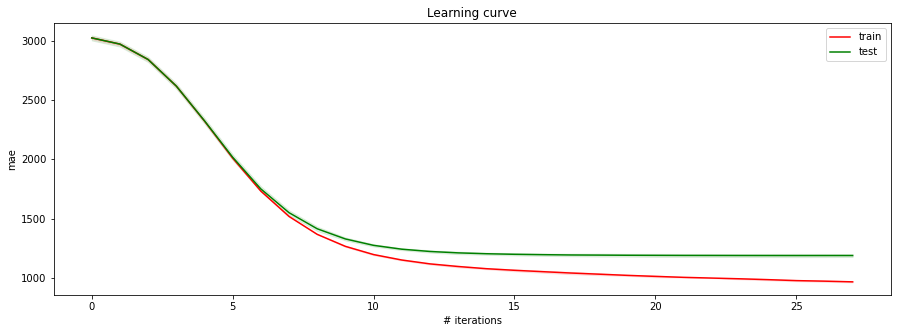

(1187.855608870854, 4.401912703171562)

In [35]:
feats = num_feats + cat_id_feats + sum_feats + minus_feats

xgb_params = {
    'n_estimators': 50,
    'max_depth': 10,
    'learning_rate': 0.3,
    'random_state': 2019,
    'objective': 'reg:squarederror'
}
cv_xgb(train, feats, xgb_params, shift=shift)

Еще одно улучшение: ~**1187** vs ~**1209**.



## Normalize `numerical` variables

In [40]:
all_cont_feats = [feat for feat in train.columns if feat.startswith('cont')]
[ (feat, train[feat].skew()) for feat in all_cont_feats ]

[('cont1', 0.5164240212162501),
 ('cont2', -0.3109412513683013),
 ('cont3', -0.010002283912088425),
 ('cont4', 0.41609602949567703),
 ('cont5', 0.6816224364137877),
 ('cont6', 0.4612142679626868),
 ('cont7', 0.8260528331279865),
 ('cont8', 0.6766340713246528),
 ('cont9', 1.0724287198115823),
 ('cont10', 0.35500094742512944),
 ('cont11', 0.28082142843754204),
 ('cont12', 0.29199208040362884),
 ('cont13', 0.38074220048057467),
 ('cont14', 0.24867408719289721)]

In [41]:
for feat in tqdm(all_cont_feats):
    if train[feat].skew() < 0.25: continue
    train[feat + '_sqrt'] = np.sqrt( minmax_scale(train[feat]) )
    train[feat + '_log1p'] = np.log1p( minmax_scale(train[feat]) )
    
sqrt_cont_feats = [feat for feat in train.columns if feat.startswith('cont') and 'sqrt' in feat]
log_cont_feats = [feat for feat in train.columns if feat.startswith('cont') and 'log' in feat]

100%|██████████| 14/14 [00:00<00:00, 90.07it/s]


3it [02:53, 57.81s/it]


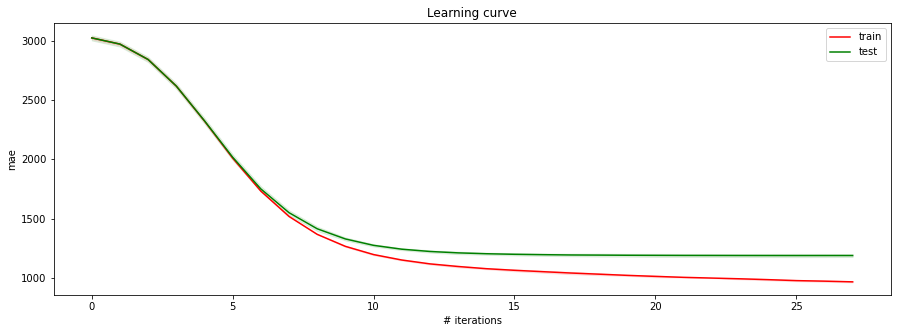

(1187.855608870854, 4.401912703171562)

In [42]:
feats = num_feats + cat_id_feats + sum_feats + minus_feats + sqrt_cont_feats + log_cont_feats

xgb_params = {
    'n_estimators': 50,
    'max_depth': 10,
    'learning_rate': 0.3,
    'random_state': 0,
    'objective': 'reg:squarederror',
}
cv_xgb(train, feats, xgb_params, shift=1)

### Смещение `log(loss + shift)`


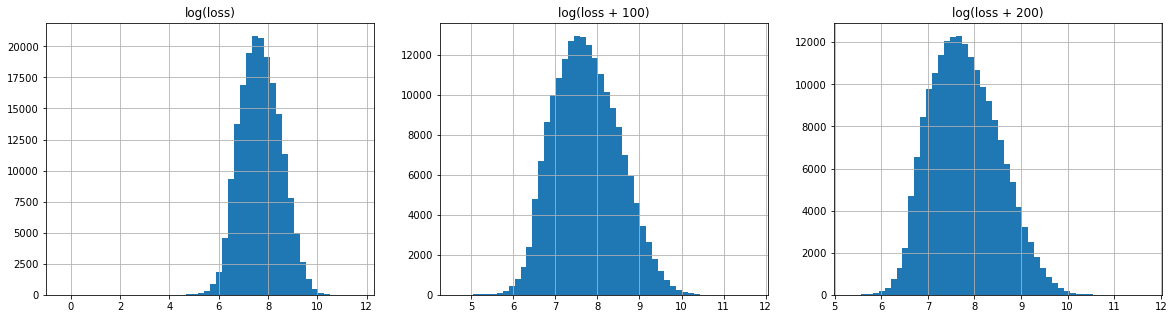

In [43]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
np.log( train['loss'] ).hist(bins=50)
plt.title('log(loss)')

plt.subplot(132)
np.log( train['loss'] + 100).hist(bins=50)
plt.title('log(loss + 100)')

plt.subplot(133)
np.log( train['loss'] + 200).hist(bins=50)
plt.title('log(loss + 200)');

3it [02:38, 52.80s/it]


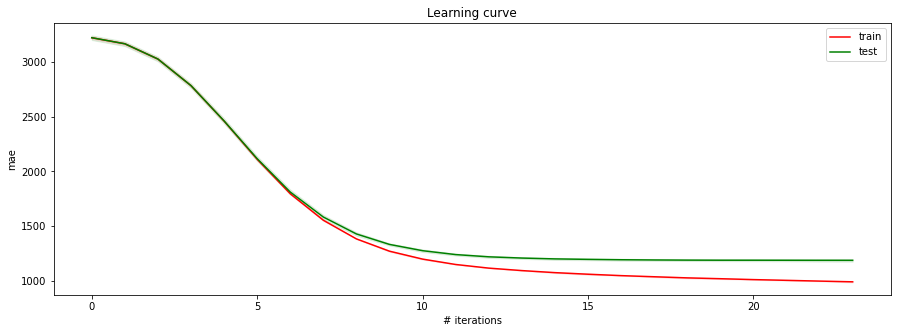

(1188.1086885398415, 3.9428601091218725)

In [40]:
cv_xgb(train, feats, xgb_params, shift=200)

## Hyperopt


{'max_depth': 10, 'colsample_bytree': 0.9854514470840767, 'learning_rate': 0.08631325628504544, 'subsample': 0.744104435810774, 'seed': 0, 'min_child_weight': 80, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                
5                                                     
  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

0it [00:00, ?it/s]

1it [03:28, 208.29s/it]

2it [06:33, 194.96s/it]

3it [09:40, 190.97s/it]

3it [09:40, 193.40s/it]


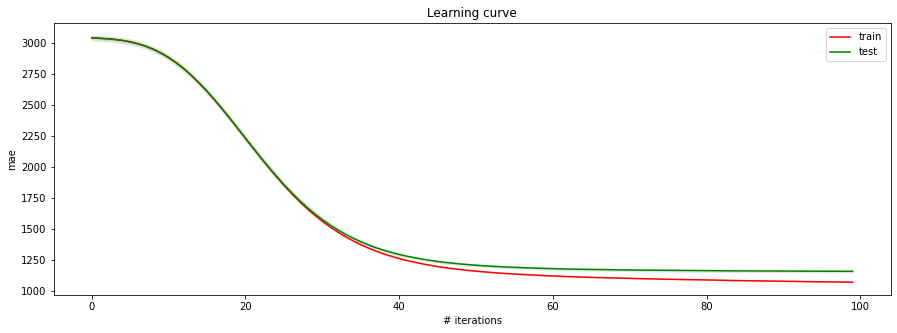

score:                                                
1155.2415433735848                                    
3.0748080615685027                                    
{'max_depth': 10, 'colsample_bytree': 0.9893334607465966, 'learning_rate': 0.07167915816959358, 'subsample': 0.7171983801764711, 'seed': 0, 'min_child_weight': 70, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                             
12                                                                                 
  3%|▎         | 1/30 [09:40<4:40:38, 580.64s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [03:11, 191.45s/it]

2it [07:38, 236.00s/it]

3it [11:20, 229.49s/it]

3it [11:20, 226.80s/it]


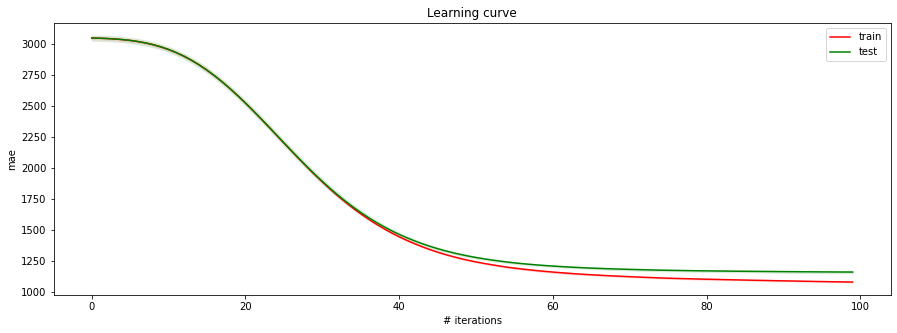

score:                                                                             
1158.5314909883443                                                                 
3.293616097408973                                                                  
{'max_depth': 9, 'colsample_bytree': 0.45181163618744535, 'learning_rate': 0.18566320204645775, 'subsample': 0.995990999280016, 'seed': 0, 'min_child_weight': 190, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                             
9                                                                                  
  7%|▋         | 2/30 [21:01<4:58:30, 639.64s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [01:24, 84.17s/it]

2it [02:39, 78.68s/it]

3it [04:01, 80.41s/it]

3it [04:01, 80.50s/it]


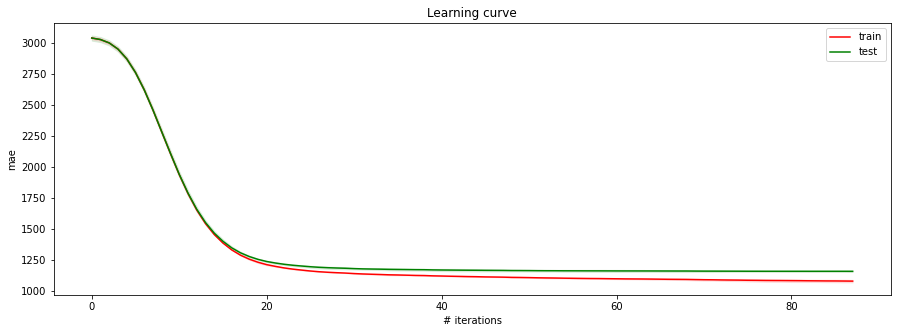

score:                                                                             
1155.8469943103369                                                                 
2.068225880402813                                                                  
{'max_depth': 5, 'colsample_bytree': 0.9905025629253899, 'learning_rate': 0.05080484167425431, 'subsample': 0.6053933884339995, 'seed': 0, 'min_child_weight': 10, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                             
193                                                                                
 10%|█         | 3/30 [25:03<3:26:08, 458.10s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [01:56, 116.09s/it]

2it [03:41, 109.91s/it]

3it [05:25, 106.94s/it]

3it [05:25, 108.36s/it]


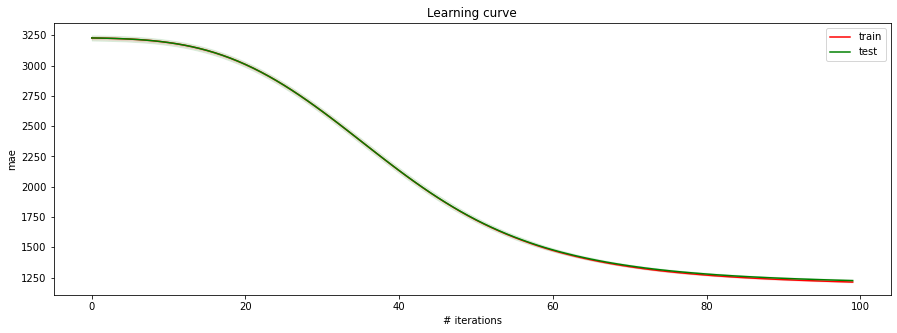

score:                                                                             
1224.6391499821416                                                                 
3.332344955740936                                                                  
{'max_depth': 7, 'colsample_bytree': 0.7537619674337152, 'learning_rate': 0.12924003122342553, 'subsample': 0.9345504984740772, 'seed': 0, 'min_child_weight': 160, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                             
106                                                                                
 13%|█▎        | 4/30 [30:29<2:55:50, 405.77s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [01:39, 99.63s/it]

2it [03:18, 99.07s/it]

3it [04:56, 98.76s/it]

3it [04:56, 98.90s/it]


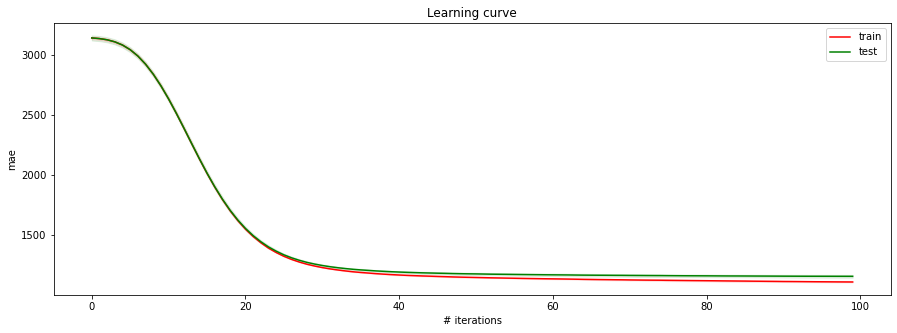

score:                                                                             
1156.0781844957587                                                                 
3.9231435833227355                                                                 
{'max_depth': 8, 'colsample_bytree': 0.21411437504692227, 'learning_rate': 0.10498837060372154, 'subsample': 0.8149035041715202, 'seed': 0, 'min_child_weight': 90, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                             
66                                                                                 
 17%|█▋        | 5/30 [35:26<2:32:44, 366.60s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [00:54, 54.10s/it]

2it [01:48, 54.04s/it]

3it [02:41, 53.96s/it]

3it [02:41, 53.99s/it]


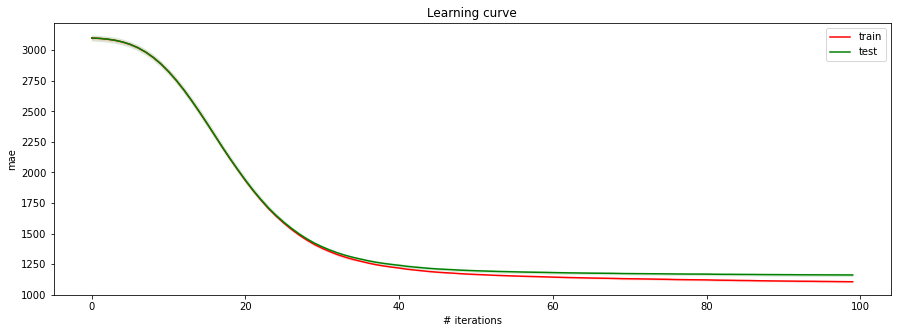

score:                                                                             
1161.3482656410963                                                                 
3.0641370663364773                                                                 
{'max_depth': 10, 'colsample_bytree': 0.7269940740932641, 'learning_rate': 0.19538189359922653, 'subsample': 0.6028390293051664, 'seed': 0, 'min_child_weight': 20, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                             
138                                                                                
 20%|██        | 6/30 [38:08<1:58:52, 297.18s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [01:22, 82.28s/it]

2it [02:52, 86.68s/it]

3it [04:29, 91.41s/it]

3it [04:29, 89.69s/it]


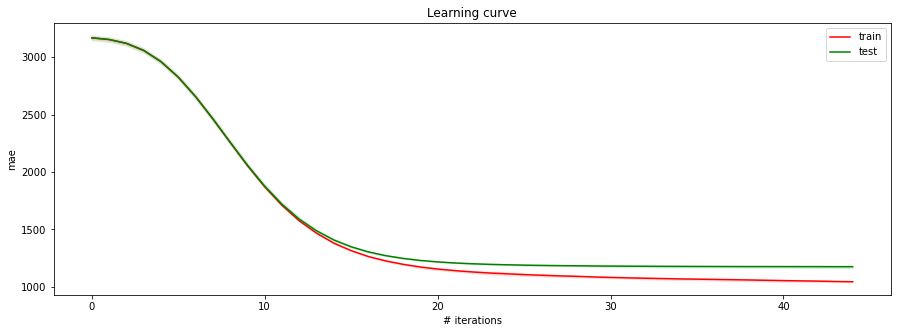

score:                                                                             
1174.5276245926495                                                                 
3.8648050754247163                                                                 
{'max_depth': 7, 'colsample_bytree': 0.4968369071756986, 'learning_rate': 0.1435820820005213, 'subsample': 0.7959694992081117, 'seed': 0, 'min_child_weight': 140, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                             
47                                                                                 
 23%|██▎       | 7/30 [42:38<1:50:28, 288.18s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [01:18, 78.79s/it]

2it [02:37, 78.57s/it]

3it [03:55, 78.57s/it]

3it [03:55, 78.59s/it]


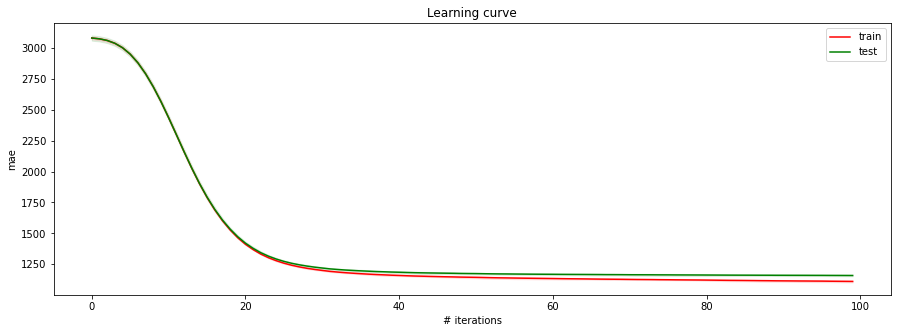

score:                                                                             
1159.2094546237302                                                                 
2.066507483674482                                                                  
{'max_depth': 6, 'colsample_bytree': 0.823116335779607, 'learning_rate': 0.09053014788600937, 'subsample': 0.7001283110504867, 'seed': 0, 'min_child_weight': 50, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                             
180                                                                                
 27%|██▋       | 8/30 [46:34<1:39:36, 271.64s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [01:44, 104.03s/it]

2it [03:27, 103.65s/it]

3it [05:10, 103.45s/it]

3it [05:10, 103.54s/it]


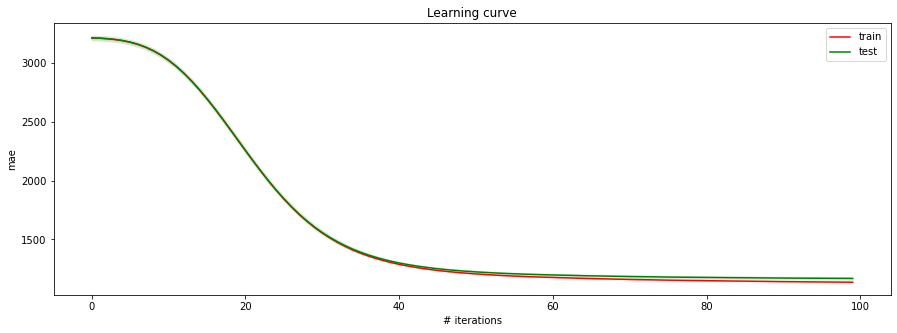

score:                                                                             
1168.5725562028765                                                                 
3.9750537639755925                                                                 
{'max_depth': 9, 'colsample_bytree': 0.23861041395586857, 'learning_rate': 0.16240883357841668, 'subsample': 0.8924772997071738, 'seed': 0, 'min_child_weight': 120, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                             
46                                                                                 
 30%|███       | 9/30 [51:45<1:39:23, 283.97s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [01:01, 61.51s/it]

2it [02:02, 61.21s/it]

3it [03:02, 60.83s/it]

3it [03:02, 60.96s/it]


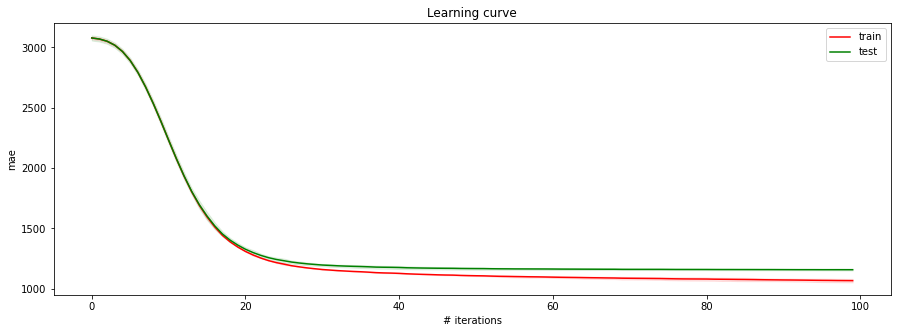

score:                                                                             
1158.5907938033235                                                                 
2.086528081004178                                                                  
{'max_depth': 9, 'colsample_bytree': 0.8974148139664774, 'learning_rate': 0.05133717130301032, 'subsample': 0.6723117694790715, 'seed': 0, 'min_child_weight': 190, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                              
99                                                                                  
 33%|███▎      | 10/30 [54:49<1:24:17, 252.89s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [02:38, 158.78s/it]

2it [05:34, 168.98s/it]

3it [08:36, 174.71s/it]

3it [08:36, 172.14s/it]


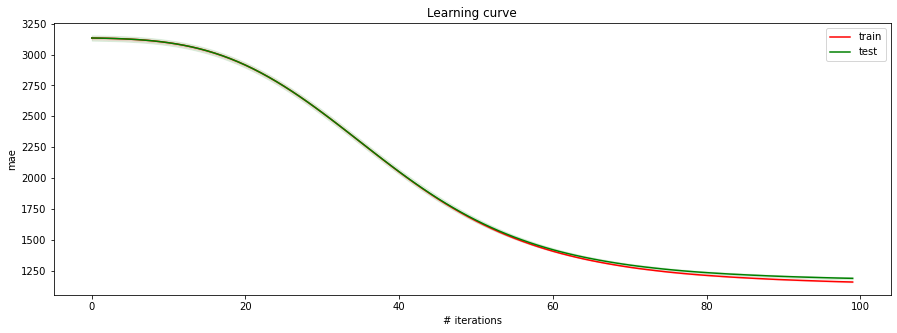

score:                                                                              
1186.478851110943                                                                     
3.091562936885968                                                                     
{'max_depth': 8, 'colsample_bytree': 0.6114320194555043, 'learning_rate': 0.09556943058842796, 'subsample': 0.7961189399149821, 'seed': 0, 'min_child_weight': 50, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                                
10                                                                                    
 37%|███▋      | 11/30 [1:03:26<1:45:40, 333.72s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [02:10, 130.31s/it]

2it [03:53, 114.52s/it]

3it [06:03, 121.47s/it]

3it [06:03, 121.19s/it]


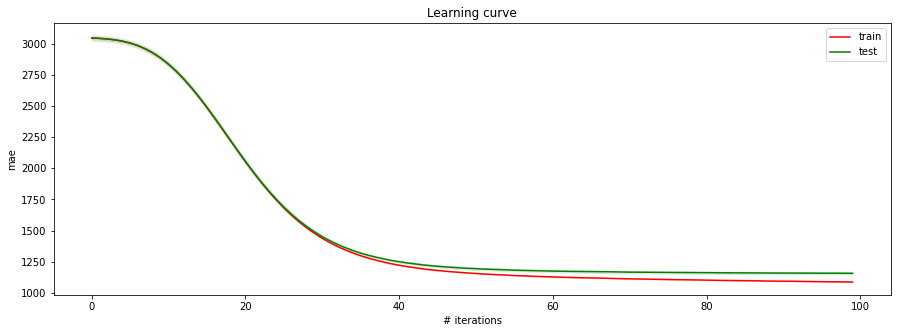

score:                                                                                
1157.7644128610766                                                                    
3.043993835055131                                                                     
{'max_depth': 5, 'colsample_bytree': 0.3571126838672754, 'learning_rate': 0.16245192646902035, 'subsample': 0.8622107075802554, 'seed': 0, 'min_child_weight': 100, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                                
149                                                                                   
 40%|████      | 12/30 [1:09:30<1:42:53, 342.97s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [00:54, 54.22s/it]

2it [02:01, 62.00s/it]

3it [02:50, 55.98s/it]

3it [02:50, 56.82s/it]


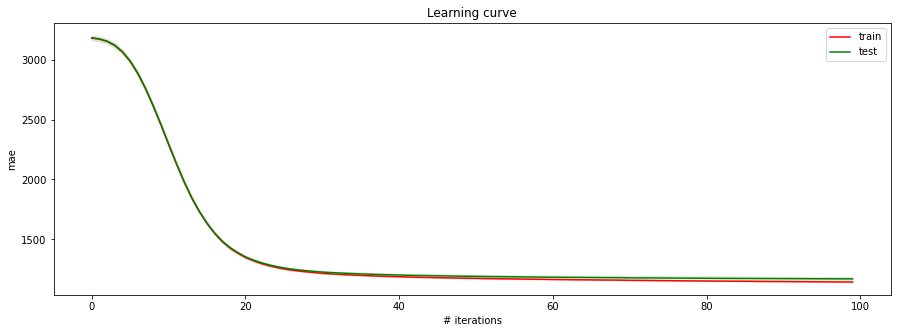

score:                                                                                
1169.678042680502                                                                     
5.142338969987607                                                                     
{'max_depth': 10, 'colsample_bytree': 0.6353638569556372, 'learning_rate': 0.07216554203911354, 'subsample': 0.9967702923606586, 'seed': 0, 'min_child_weight': 160, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                                
83                                                                                    
 43%|████▎     | 13/30 [1:12:21<1:22:24, 290.86s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [01:59, 119.89s/it]

2it [03:59, 119.54s/it]

3it [05:58, 119.55s/it]

3it [05:58, 119.60s/it]


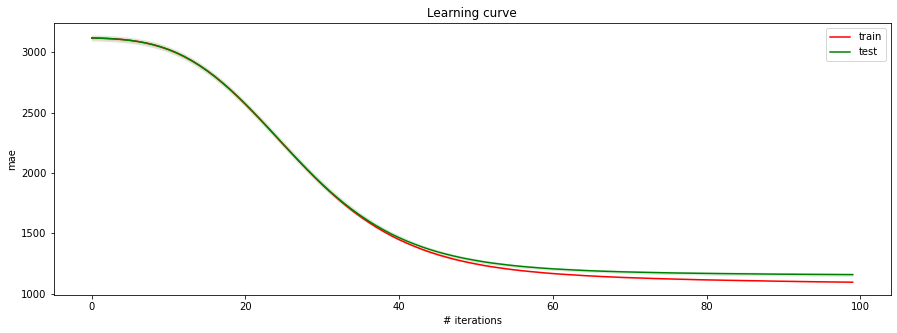

score:                                                                                
1157.7767028489513                                                                    
3.3203935268108955                                                                    
{'max_depth': 6, 'colsample_bytree': 0.8961228189155016, 'learning_rate': 0.1179341957477398, 'subsample': 0.7431413728804946, 'seed': 0, 'min_child_weight': 30, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                                
35                                                                                    
 47%|████▋     | 14/30 [1:18:20<1:23:04, 311.51s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [01:47, 107.00s/it]

2it [03:33, 106.88s/it]

3it [05:20, 106.98s/it]

3it [05:20, 106.96s/it]


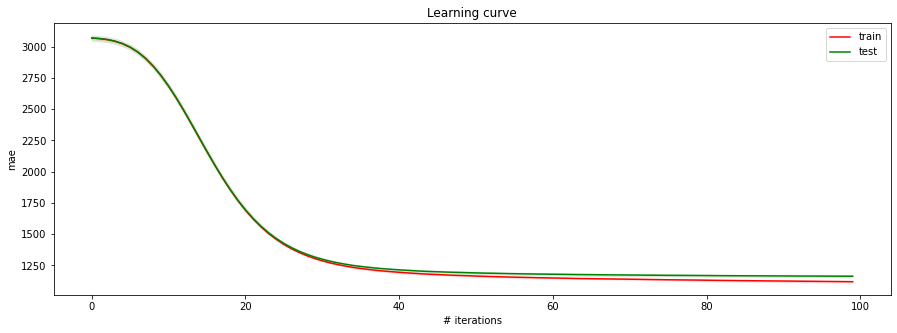

score:                                                                                
1163.8832765878733                                                                    
3.08141650768724                                                                      
{'max_depth': 9, 'colsample_bytree': 0.9893613002444698, 'learning_rate': 0.07134095972878066, 'subsample': 0.6562973986847702, 'seed': 0, 'min_child_weight': 80, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                                
131                                                                                   
 50%|█████     | 15/30 [1:23:41<1:18:37, 314.47s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [02:55, 175.68s/it]

2it [05:51, 175.87s/it]

3it [08:45, 175.06s/it]

3it [08:45, 175.26s/it]


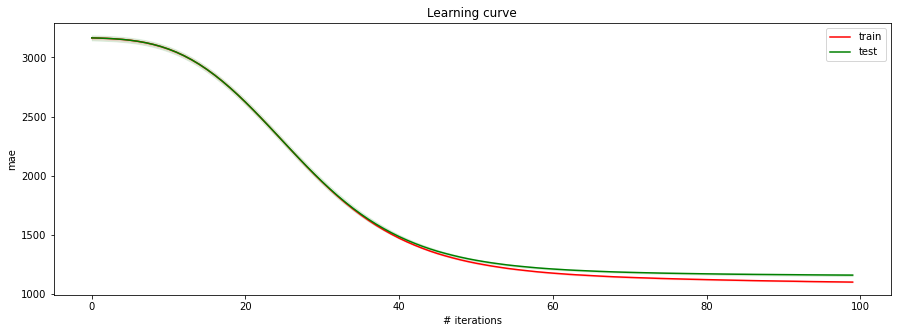

score:                                                                                
1160.9371909418305                                                                    
2.7099985460558735                                                                    
{'max_depth': 8, 'colsample_bytree': 0.5126169048644951, 'learning_rate': 0.14540891348972704, 'subsample': 0.9426006832180986, 'seed': 0, 'min_child_weight': 130, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                                
169                                                                                   
 53%|█████▎    | 16/30 [1:32:27<1:28:14, 378.21s/trial, best loss: 1155.2415433735848]

0it [00:00, ?it/s]

1it [01:26, 86.29s/it]

2it [02:52, 86.36s/it]

3it [04:18, 86.03s/it]

3it [04:18, 86.11s/it]


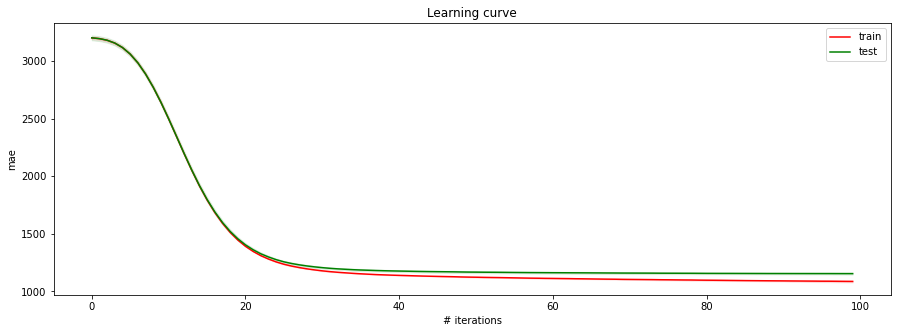

score:                                                                                
1154.2573867721549                                                                    
2.7872439996948484                                                                    
{'max_depth': 8, 'colsample_bytree': 0.506845441436865, 'learning_rate': 0.14500168077009698, 'subsample': 0.9321837383120509, 'seed': 0, 'min_child_weight': 130, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                                
166                                                                                   
 57%|█████▋    | 17/30 [1:36:46<1:14:09, 342.30s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [01:25, 85.84s/it]

2it [02:51, 85.50s/it]

3it [04:16, 85.52s/it]

3it [04:16, 85.55s/it]


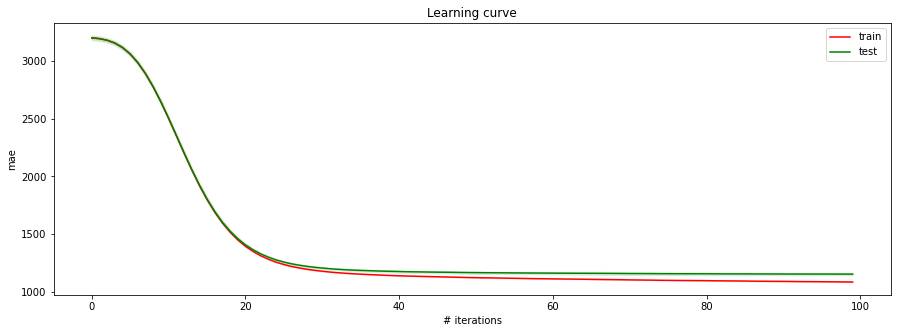

score:                                                                                
1154.4668594507566                                                                    
3.6192853711445996                                                                    
{'max_depth': 8, 'colsample_bytree': 0.5076885831709055, 'learning_rate': 0.1555966037078054, 'subsample': 0.9429753583691369, 'seed': 0, 'min_child_weight': 130, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                                
168                                                                                   
 60%|██████    | 18/30 [1:41:03<1:03:20, 316.71s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [01:25, 85.30s/it]

2it [02:50, 85.20s/it]

3it [04:14, 84.78s/it]

3it [04:14, 84.91s/it]


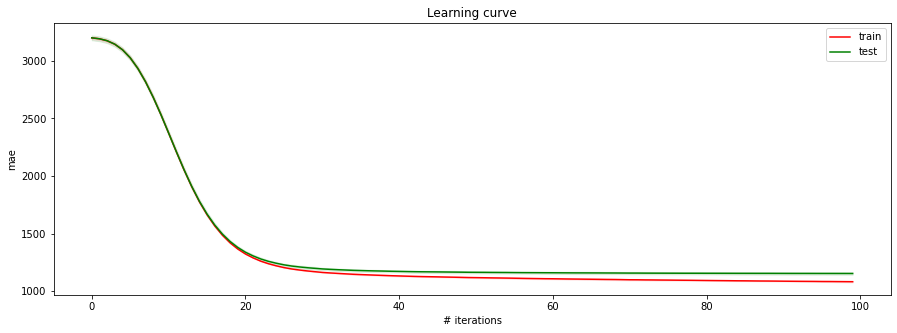

score:                                                                                
1154.5805129234934                                                                    
3.583918616101633                                                                     
{'max_depth': 7, 'colsample_bytree': 0.3431673535891651, 'learning_rate': 0.17508568841215644, 'subsample': 0.9437794303722421, 'seed': 0, 'min_child_weight': 160, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                              
195                                                                                 
 63%|██████▎   | 19/30 [1:45:19<54:40, 298.23s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [00:59, 59.72s/it]

2it [01:58, 59.29s/it]

3it [02:58, 59.38s/it]

3it [02:58, 59.40s/it]


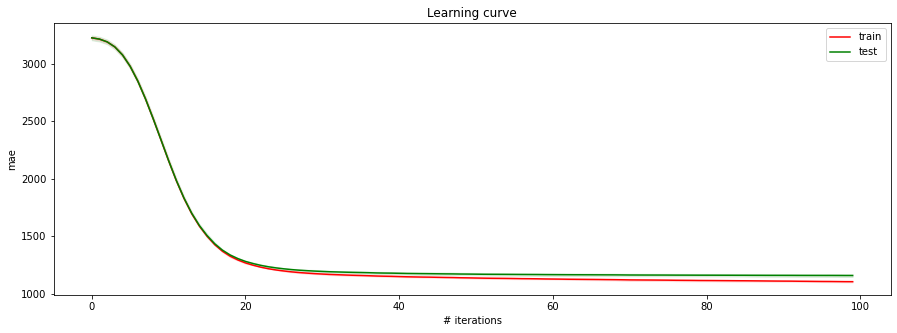

score:                                                                              
1157.7149553976362                                                                  
4.309599049957077                                                                   
{'max_depth': 8, 'colsample_bytree': 0.4048048229665318, 'learning_rate': 0.1408155872083791, 'subsample': 0.887382405828327, 'seed': 0, 'min_child_weight': 120, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                              
161                                                                                 
 67%|██████▋   | 20/30 [1:48:17<43:43, 262.33s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [01:16, 76.19s/it]

2it [02:31, 75.80s/it]

3it [03:47, 75.78s/it]

3it [03:47, 75.82s/it]


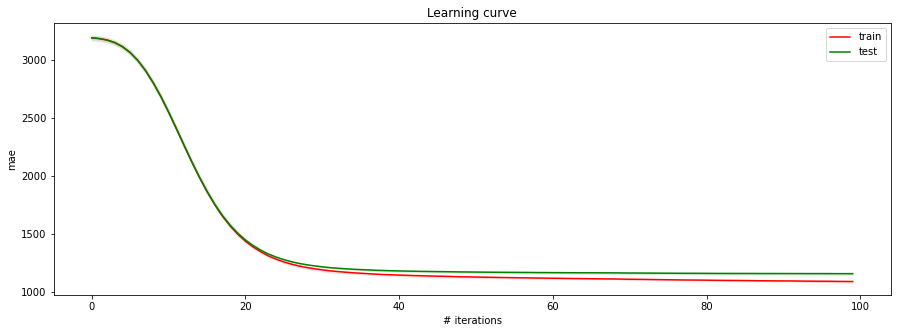

score:                                                                              
1154.9405228805465                                                                  
3.008985429566009                                                                   
{'max_depth': 7, 'colsample_bytree': 0.5445122268522666, 'learning_rate': 0.12252423845024525, 'subsample': 0.9726551192684803, 'seed': 0, 'min_child_weight': 140, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                              
122                                                                                 
 70%|███████   | 21/30 [1:52:05<37:48, 252.05s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [01:18, 78.46s/it]

2it [02:36, 78.18s/it]

3it [03:54, 78.15s/it]

3it [03:54, 78.19s/it]


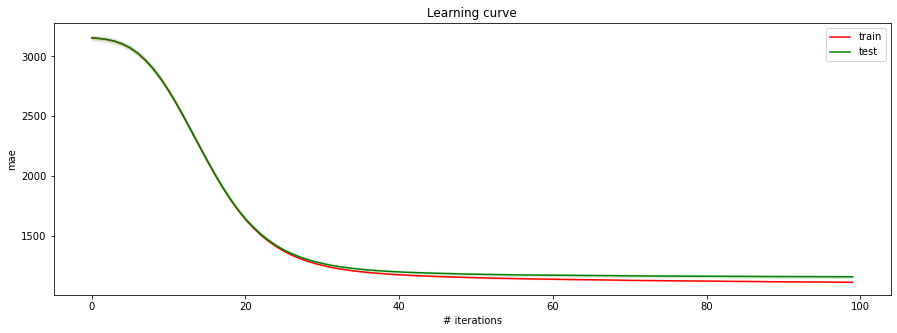

score:                                                                              
1157.3871369686733                                                                  
3.552609915158151                                                                   
{'max_depth': 8, 'colsample_bytree': 0.6644390323705593, 'learning_rate': 0.14025830508216772, 'subsample': 0.847739173577034, 'seed': 0, 'min_child_weight': 170, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                              
199                                                                                 
 73%|███████▎  | 22/30 [1:56:00<32:55, 246.94s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [01:44, 104.65s/it]

2it [03:29, 104.56s/it]

3it [05:13, 104.49s/it]

3it [05:13, 104.52s/it]


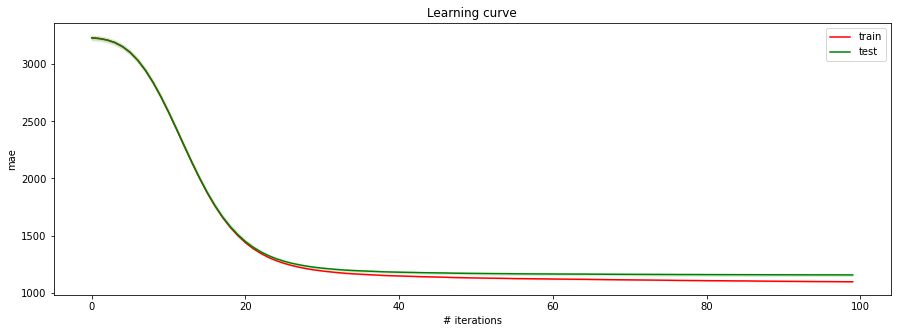

score:                                                                              
1155.5079207581691                                                                  
3.158219239355138                                                                   
{'max_depth': 6, 'colsample_bytree': 0.5599830115392717, 'learning_rate': 0.17655872367637454, 'subsample': 0.9074776921939053, 'seed': 0, 'min_child_weight': 110, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                              
176                                                                                 
 77%|███████▋  | 23/30 [2:01:14<31:09, 267.08s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [01:12, 72.21s/it]

2it [02:23, 71.96s/it]

3it [03:35, 71.70s/it]

3it [03:35, 71.79s/it]


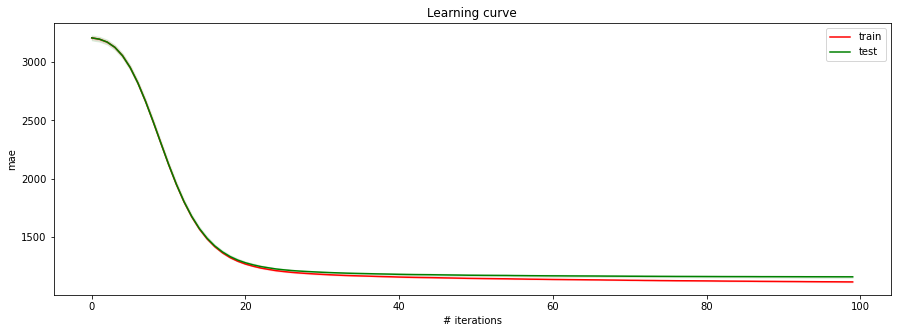

score:                                                                              
1159.2620807640644                                                                  
2.511136385528696                                                                   
{'max_depth': 9, 'colsample_bytree': 0.2951836687363932, 'learning_rate': 0.15274019848439005, 'subsample': 0.8376048290197818, 'seed': 0, 'min_child_weight': 140, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                              
150                                                                                 
 80%|████████  | 24/30 [2:04:50<25:10, 251.69s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [01:08, 68.81s/it]

2it [02:17, 68.62s/it]

3it [03:24, 67.74s/it]

3it [03:24, 68.00s/it]


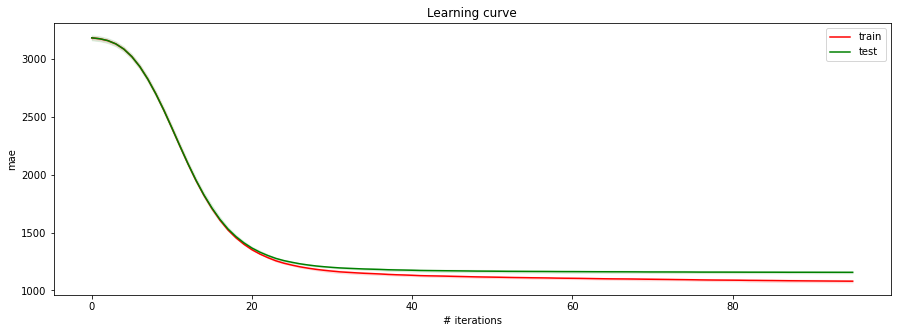

score:                                                                              
1156.6169965378751                                                                  
2.496112791572747                                                                   
{'max_depth': 8, 'colsample_bytree': 0.44257302815031396, 'learning_rate': 0.11341780879453693, 'subsample': 0.9624805602879399, 'seed': 0, 'min_child_weight': 180, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                              
114                                                                                 
 83%|████████▎ | 25/30 [2:08:15<19:47, 237.51s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [01:16, 76.38s/it]

2it [02:32, 76.36s/it]

3it [03:49, 76.40s/it]

3it [03:49, 76.41s/it]


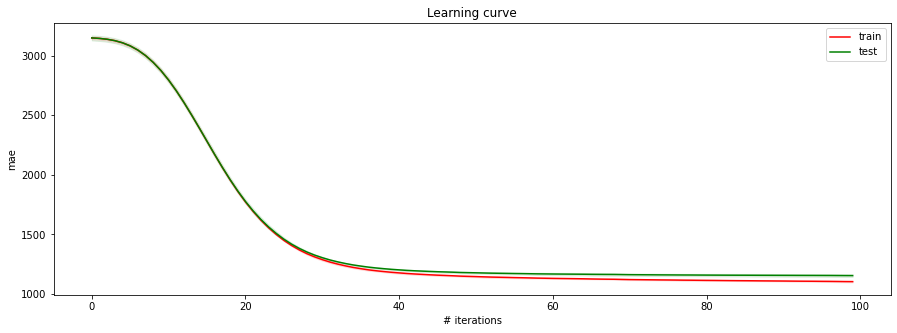

score:                                                                              
1155.4305944620985                                                                  
3.6109110950564243                                                                  
{'max_depth': 7, 'colsample_bytree': 0.6735749218757129, 'learning_rate': 0.13449523826386886, 'subsample': 0.9108063565113864, 'seed': 0, 'min_child_weight': 110, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                              
183                                                                                 
 87%|████████▋ | 26/30 [2:12:04<15:40, 235.15s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [01:32, 92.64s/it]

2it [03:05, 92.61s/it]

3it [04:38, 93.01s/it]

3it [04:38, 92.91s/it]


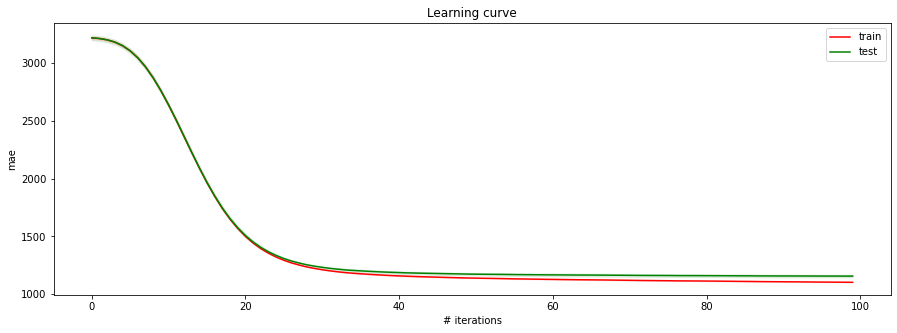

score:                                                                              
1157.0755328766165                                                                  
3.9034356996073427                                                                  
{'max_depth': 9, 'colsample_bytree': 0.29469777998413527, 'learning_rate': 0.1981534017239337, 'subsample': 0.9975361529412271, 'seed': 0, 'min_child_weight': 150, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                              
156                                                                                 
 90%|█████████ | 27/30 [2:16:43<12:25, 248.36s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [01:05, 65.74s/it]

2it [01:55, 56.56s/it]

3it [03:00, 60.04s/it]

3it [03:00, 60.02s/it]


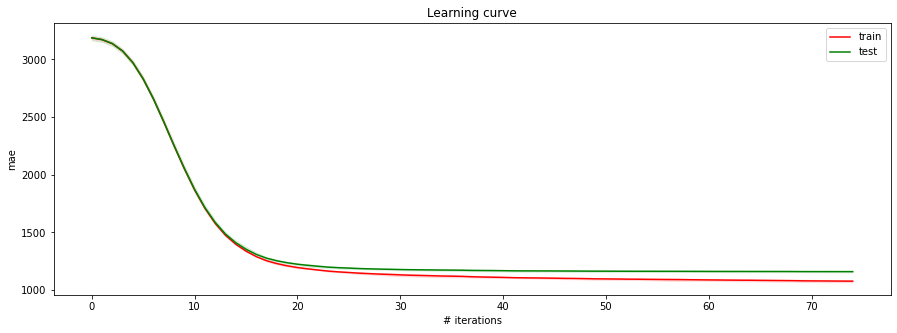

score:                                                                              
1158.6881820071183                                                                  
3.2379774998521387                                                                  
{'max_depth': 8, 'colsample_bytree': 0.571289818337758, 'learning_rate': 0.1703871654135998, 'subsample': 0.7667149923969917, 'seed': 0, 'min_child_weight': 70, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                              
137                                                                                 
 93%|█████████▎| 28/30 [2:19:44<07:35, 228.00s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [01:37, 97.14s/it]

2it [03:14, 97.31s/it]

3it [04:50, 96.57s/it]

3it [04:50, 96.76s/it]


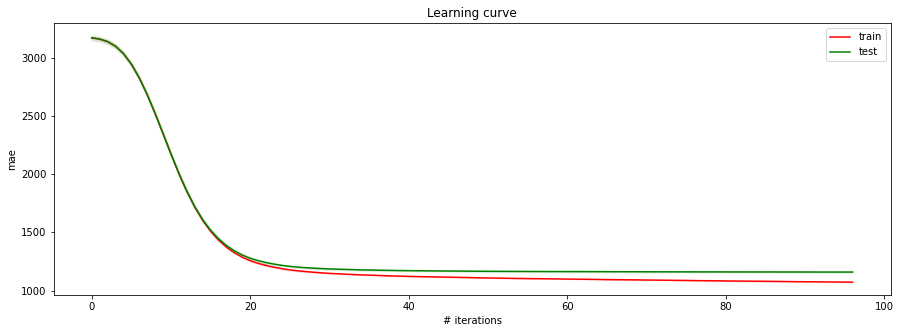

score:                                                                              
1158.648840025579                                                                   
1.7930988738051528                                                                  
{'max_depth': 7, 'colsample_bytree': 0.4715907808019789, 'learning_rate': 0.10259760567952496, 'subsample': 0.8717933107521013, 'seed': 0, 'min_child_weight': 100, 'n_estimators': 100, 'objective': 'reg:squarederror'}
shift:                                                                              
84                                                                                  
 97%|█████████▋| 29/30 [2:24:35<04:06, 246.80s/trial, best loss: 1154.2573867721549]

0it [00:00, ?it/s]

1it [01:15, 75.28s/it]

2it [02:29, 74.72s/it]

3it [03:44, 74.97s/it]

3it [03:44, 74.96s/it]


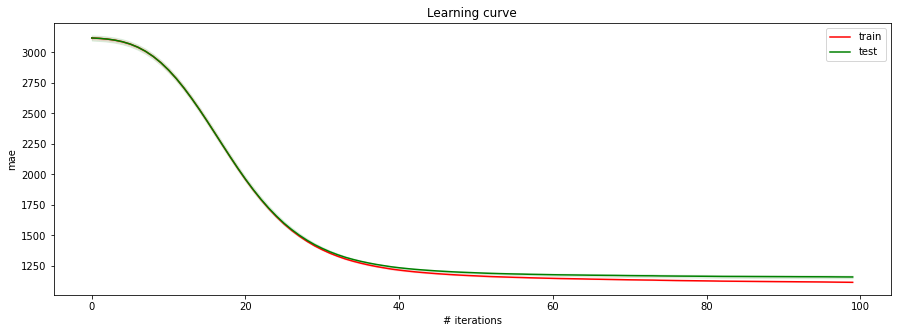

score:                                                                              
1159.3421134384505                                                                  
3.788876169178564                                                                   
100%|██████████| 30/30 [2:28:20<00:00, 296.68s/trial, best loss: 1154.2573867721549]
The best params:  {'x_colsample_bytree': 0.5126169048644951, 'x_learning_rate': 0.14540891348972704, 'x_max_depth': 8.0, 'x_min_child_weight': 130.0, 'x_shift': 169.0, 'x_subsample': 0.9426006832180986}
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [41]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': 0, #int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        #'reg_alpha': space['reg_alpha'],
        #'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
        'objective': 'reg:squarederror',
    }
    shift = int(space['shift'])
    print(xgb_params)
    print("shift: ", shift)
    
    feats = num_feats + cat_id_feats + sum_feats + minus_feats + sqrt_cont_feats + log_cont_feats
    mean_score, std_score = cv_xgb(train, feats, xgb_params, shift=shift, plot_lc=True)
    
    print("score:", mean_score, std_score)
    
    return{'loss':mean_score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 10, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.2, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.6, 1.),
    'min_child_weight': hp.quniform ('x_min_child_weight', 10, 200, 10),
    #'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    #'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
    'shift': hp.quniform ('x_shift', 1, 200, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)
%time

In [42]:
trials.best_trial

{'state': 2,
 'tid': 16,
 'spec': None,
 'result': {'loss': 1154.2573867721549, 'status': 'ok'},
 'misc': {'tid': 16,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'x_colsample_bytree': [16],
   'x_learning_rate': [16],
   'x_max_depth': [16],
   'x_min_child_weight': [16],
   'x_shift': [16],
   'x_subsample': [16]},
  'vals': {'x_colsample_bytree': [0.5126169048644951],
   'x_learning_rate': [0.14540891348972704],
   'x_max_depth': [8.0],
   'x_min_child_weight': [130.0],
   'x_shift': [169.0],
   'x_subsample': [0.9426006832180986]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 11, 9, 14, 30, 33, 63000),
 'refresh_time': datetime.datetime(2021, 11, 9, 14, 34, 51, 823000)}

3it [04:13, 84.51s/it]


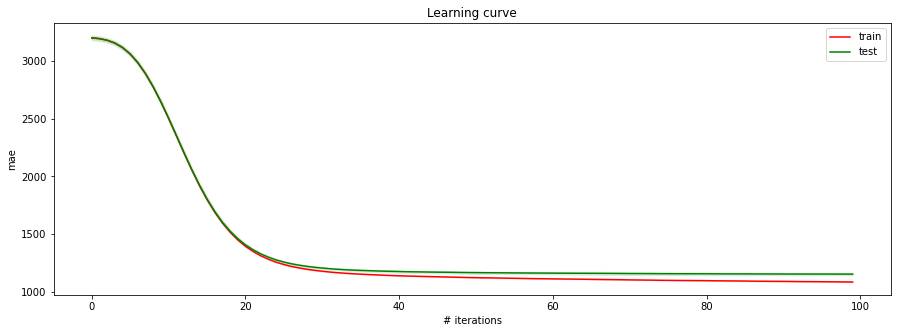

(1154.4668594507566, 3.6192853711445996)

In [44]:
feats = num_feats + cat_id_feats + sum_feats + minus_feats + sqrt_cont_feats + log_cont_feats

xgb_params = {
    'max_depth': 8, 
    'colsample_bytree': 0.506845441436865, 
    'learning_rate': 0.14500168077009698, 
    'subsample': 0.9321837383120509, 
    'seed': 0, 
    'min_child_weight': 130, 
    'n_estimators': 100, 
    'objective': 'reg:squarederror'
}
cv_xgb(train, feats, xgb_params, shift=166)
